In [1]:
from bs4 import BeautifulSoup as bs
from urllib.parse import urlparse
from urllib.request import Request, urlopen
import urllib
import re
import requests
import csv
import pandas as pd
from datetime import datetime, date
import yfinance as yf

## Website with directions
https://blog.jovian.ai/web-scraping-yahoo-finance-using-python-7c4612fab70c

### Main Yahoo Finance Webscraping

In [50]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""

    headers = {
    'authority': 'www.spot.im',
    'accept': 'application/json',
    'accept-language': 'en-US,en;q=0.9',
    'content-type': 'application/json',
    # Requests sorts cookies= alphabetically
    'cookie': 'device_uuid=80e01093-d9cb-4199-9a8d-5302402b793a; access_token=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJlbWFpbCI6IiIsInZlcmlmaWVkIjpmYWxzZSwidXNlcl9pZCI6InVfS2tRM2pYV1lDN3JLIiwiZGlzcGxheV9uYW1lIjoiT3JhbmdlQ29uZSIsInVzZXJfbmFtZSI6Ik9yYW5nZUNvbmUiLCJyZWdpc3RlcmVkIjpmYWxzZSwiaW1hZ2VfaWQiOiIjT3JhbmdlLUNvbmUiLCJyb2xlcyI6W10sInNzb19kYXRhIjpudWxsLCJwcm92aWRlcnMiOm51bGwsInJlcHV0YXRpb24iOnt9LCJzcG90X2lkIjoic3BfUmJhOWFGcEciLCJsYXN0X2NoZWNrIjoxNjY5NzU3MjQ2LCJ2ZXJzaW9uIjo0LCJ4LXNwb3RpbS10b2tlbiI6IjAxMjIxMTI5ZXRSQzFMLjUxZjQzNDEwMWE3NTQ3YzdmOGIxYTE3NDIxMTg3MTA1ZDZiNTY0YjM5MDhkM2ViNTIzZmU5M2FiMGNjYWNiZjAiLCJwZXJtaXNzaW9ucyI6bnVsbCwic3BvdGltLWRldmljZS12MiI6ImRfVzMwRURPVFZkcUpjSjdBTzVpT3YiLCJuZXR3b3JrIjp7Im5ldHdvcmtfaWQiOiJuZXRfeWFob28iLCJuZXR3b3JrX25hbWUiOiJ5YWhvbyIsIm5ldHdvcmtfaW1hZ2VfaWQiOiI5ZDAwMWIwMTMxMzIyYTBiMmFmYWM1MjYyMGU3MzI4MSIsIm5ldHdvcmtfY29sb3IiOiIifSwic3BvdF9uYW1lIjoiIiwiZG9tYWluIjoiIiwicm9sZXNfbnVtYmVyIjowLCJ0ZW1wX3VzZXIiOmZhbHNlLCJleHAiOjE2Njk3NjA4NDYsInN1YiI6InVfS2tRM2pYV1lDN3JLIn0.u-U5dUwDE5pGhfMtOgju8_mD6vnJW2tgb8iOB3jCy_k; spotim-device-v2=d_W30EDOTVdqJcJ7AO5iOv',
    'origin': 'https://openweb.jac.yahoosandbox.com',
    'referer': 'https://openweb.jac.yahoosandbox.com/0.8.1/safeframe.html',
    'sec-ch-ua': '"Microsoft Edge";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'cross-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 Edg/107.0.1418.56',
    'x-spotim-device-uuid': '80e01093-d9cb-4199-9a8d-5302402b793a',
    'x-spotim-page-view-id': '343b3bd3-f548-46c3-935e-30e483be67c2',
    'x-spotim-spotid': 'sp_Rba9aFpG',
    'x-spotim-token': '01221129etRC1L.51f434101a7547c7f8b1a17421187105d6b564b3908d3eb523fe93ab0ccacbf0',
    }
    
    response = requests.get(url, headers=headers)
    
    if not response.ok:
        print('Status code - get_page:', response.status_code)
        doc = ""
        # raise Exception('Failed to load page {}'.format(url))
    else:
        page_content = response.text
        doc = bs(page_content, 'html.parser')

    return doc


In [51]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [52]:
def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    
    base_url = 'https://ca.finance.yahoo.com'
    news_source = news_tag.find('div').text #source
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link
    return { 'source' : news_source,
            'headline' : news_headline,
            'url' : base_url + news_url
           }

In [53]:
def scrape_yahoo_news(ticker):
    """Get the yahoo finance market news and write them to CSV file """
    
    yahoo_url = 'https://ca.finance.yahoo.com/quote/'
    url = yahoo_url + ticker
    
    doc = get_page(url)
    news_list = get_news_tags(doc)
    news_data = [parse_news(news_tag) for news_tag in news_list]
    news_df = pd.DataFrame(news_data)

    return news_df 

### Individual Article Page Scraping Functions

In [54]:
def parse_paragraphs(doc):
    """Get the list of tags containing news information"""
    if doc == "":
        news_list = ""
    else:
        news_class = "caas-body" ## class name of div tag 
        news_list  = doc.find_all('div', {'class': news_class})
    
    return news_list

In [55]:
def parse_news_article(news_tag):
    print('-----------------')
    if news_tag == "":
        body_string = ""
    else:
        table = news_tag[0].find_all('p')
        para_list = []
        body_string = ''
        
        for x in table:
            para_list.append(x.text)

        for x in para_list:
            body_string += ' ' + x

        body_string = body_string.replace("\"", '')
    
    return body_string

In [56]:
def get_article_date(url):
    date_class = 'caas-attr-meta-time' ## class name of time stamp
    doc = get_page(url)
    if doc == "":
        date = ""
    else:
        date_stamp = doc.find_all('time', {'class': date_class})
        date = date_stamp[0].get('datetime')
    
    return date

In [57]:
def get_article_body(url):
        
    doc = get_page(url)
    article = parse_paragraphs(doc)
    article_body = parse_news_article(article)

    return article_body

In [58]:
def dataframe_prep(news_df):

    news_df['body'] = news_df['url'].apply(lambda x: get_article_body(x))
    news_df['date'] = news_df['url'].apply(lambda x: get_article_date(x))
    news_df = news_df.drop(news_df[news_df.date == ""].index)
    news_df['date'] = pd.to_datetime(news_df['date'], format='%Y-%m-%dT%H:%M:%S.%fZ').dt.date
    news_df[['prob_posi', 'prob_nega', 'prob_neut']] = float()
    news_df['sentiment'] = int()
    news_df = news_df.reset_index()

    return news_df

### Finviz Functions

In [59]:
def fv_get_page(ticker):
    """Download a webpage and return a beautiful soup doc"""

    headers = {
    'authority': 'www.spot.im',
    'accept': 'application/json',
    'accept-language': 'en-US,en;q=0.9',
    'content-type': 'application/json',
    # Requests sorts cookies= alphabetically
    'cookie': 'device_uuid=80e01093-d9cb-4199-9a8d-5302402b793a; access_token=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJlbWFpbCI6IiIsInZlcmlmaWVkIjpmYWxzZSwidXNlcl9pZCI6InVfS2tRM2pYV1lDN3JLIiwiZGlzcGxheV9uYW1lIjoiT3JhbmdlQ29uZSIsInVzZXJfbmFtZSI6Ik9yYW5nZUNvbmUiLCJyZWdpc3RlcmVkIjpmYWxzZSwiaW1hZ2VfaWQiOiIjT3JhbmdlLUNvbmUiLCJyb2xlcyI6W10sInNzb19kYXRhIjpudWxsLCJwcm92aWRlcnMiOm51bGwsInJlcHV0YXRpb24iOnt9LCJzcG90X2lkIjoic3BfUmJhOWFGcEciLCJsYXN0X2NoZWNrIjoxNjY5NzU3MjQ2LCJ2ZXJzaW9uIjo0LCJ4LXNwb3RpbS10b2tlbiI6IjAxMjIxMTI5ZXRSQzFMLjUxZjQzNDEwMWE3NTQ3YzdmOGIxYTE3NDIxMTg3MTA1ZDZiNTY0YjM5MDhkM2ViNTIzZmU5M2FiMGNjYWNiZjAiLCJwZXJtaXNzaW9ucyI6bnVsbCwic3BvdGltLWRldmljZS12MiI6ImRfVzMwRURPVFZkcUpjSjdBTzVpT3YiLCJuZXR3b3JrIjp7Im5ldHdvcmtfaWQiOiJuZXRfeWFob28iLCJuZXR3b3JrX25hbWUiOiJ5YWhvbyIsIm5ldHdvcmtfaW1hZ2VfaWQiOiI5ZDAwMWIwMTMxMzIyYTBiMmFmYWM1MjYyMGU3MzI4MSIsIm5ldHdvcmtfY29sb3IiOiIifSwic3BvdF9uYW1lIjoiIiwiZG9tYWluIjoiIiwicm9sZXNfbnVtYmVyIjowLCJ0ZW1wX3VzZXIiOmZhbHNlLCJleHAiOjE2Njk3NjA4NDYsInN1YiI6InVfS2tRM2pYV1lDN3JLIn0.u-U5dUwDE5pGhfMtOgju8_mD6vnJW2tgb8iOB3jCy_k; spotim-device-v2=d_W30EDOTVdqJcJ7AO5iOv',
    'origin': 'https://openweb.jac.yahoosandbox.com',
    'referer': 'https://openweb.jac.yahoosandbox.com/0.8.1/safeframe.html',
    'sec-ch-ua': '"Microsoft Edge";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'cross-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36 Edg/107.0.1418.56',
    'x-spotim-device-uuid': '80e01093-d9cb-4199-9a8d-5302402b793a',
    'x-spotim-page-view-id': '343b3bd3-f548-46c3-935e-30e483be67c2',
    'x-spotim-spotid': 'sp_Rba9aFpG',
    'x-spotim-token': '01221129etRC1L.51f434101a7547c7f8b1a17421187105d6b564b3908d3eb523fe93ab0ccacbf0',
    }
   
    base_url = f'https://finviz.com/quote.ashx?t={ticker}&p=d'
    html = requests.get(base_url, headers=headers)
    
    if not html.ok:
        print('Status code - fv_page:', html.status_code)
   
    doc = bs(html.content, "html.parser")
       
    return doc

In [60]:
def fv_get_news_tags(doc):
    """Get the list of tags containing news information"""
    
    news_list  = doc.find('table', {'id': 'news-table'}) #attrs=
       
    return news_list

In [61]:
def fv_parse_news(news_tag):
    """Get the news data point and return dictionary"""

    news_source = news_tag.find('div').text #source
    news_headline = news_tag.find('a').text #heading
    news_url = news_tag.find('a')['href'] #link

    return { 'source' : news_source,
            'headline' : news_headline,
            'url' : news_url # base_url + 
           }

In [62]:
def fv_get_article_body(url):
        
    doc = fv_get_page(url)
    article = parse_paragraphs(doc)
    article_body = parse_news_article(article)

    return article_body

In [63]:
def scrape_finviz2(ticker):
    """Get the yahoo finance market news and write them to CSV file """
    
    finviz_url = f'https://finviz.com/quote.ashx?t={ticker}&p=d'
    url = finviz_url + ticker
    
    doc = get_page(url)
    news_list = get_news_tags(doc)
    news_data = [parse_news(news_tag) for news_tag in news_list]
    news_df = pd.DataFrame(news_data)

    return news_df 

In [64]:
def fv_dataframe(news_list):

    url_list = news_list.find_all('a')
    source_list = news_list.find_all('span')

    df_finviz = pd.DataFrame()
    df_finviz[['url', 'headline', 'source']] = ""

    for n in range(len(url_list)):
            url = url_list[n]['href']
            headline = url_list[n].text
            if '%' not in source_list[n].text:
                source = source_list[n].text
            else:
                pass                
                            
            if 'finance.yahoo' in url:
                df_finviz.loc[n, 'url'] = url
                df_finviz.loc[n, 'headline'] = headline
                df_finviz.loc[n, 'source'] = source
            else:
                pass

    return df_finviz


In [65]:
# def df_timed_url_grab(df_fv):

#     window_length = 10
#     num_iter = len(df_fv) // 10
#     start = 0
#     df_list = []
    
#     for n in range(num_iter):    
#         end = start + window_length
#         df_to_grab = df_fv.iloc[start:end]
#         df_partial = dataframe_prep(df_to_grab)
#         df_list.append(df_partial)
#         start = end
#         n += 1
#         time.sleep(30)
#         print(n)
        
#     df_final = pd.concat(df_list).reset_index(drop=True)

#     return df_final

## Testing - Pre Stock Price Merger

In [68]:
doc = fv_get_page('HBM')
news_list = fv_get_news_tags(doc)
df_fv = fv_dataframe(news_list)
df_final = dataframe_prep(df_fv[:10])

-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------
-----------------


C:\Users\jrilk\AppData\Local\Temp\ipykernel_20800\2352007808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['body'] = news_df['url'].apply(lambda x: get_article_body(x))
C:\Users\jrilk\AppData\Local\Temp\ipykernel_20800\2352007808.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['date'] = news_df['url'].apply(lambda x: get_article_date(x))


In [67]:
df_final

,index,url,headline,source,body,date,prob_posi,prob_nega,prob_neut,sentiment
0,0,https://finance.yahoo.com/video/china-protests...,Chinas protests made enough of impact on party...,Yahoo Finance Video,Constellation Research Principal Analyst and ...,2022-12-05,0.0,0.0,0.0,0
1,1,https://finance.yahoo.com/video/streaming-hulu...,Streaming: Hulu CEO predicts major acquisition...,Yahoo Finance Video,Yahoo Finance entertainment reporter Allie Ca...,2022-12-05,0.0,0.0,0.0,0
2,2,https://finance.yahoo.com/news/apple-store-emp...,Apple Store Employees Chide Union in Rare Disp...,Bloomberg,(Bloomberg) -- Apple Inc. retail employees pu...,2022-12-05,0.0,0.0,0.0,0
3,4,https://finance.yahoo.com/video/apple-amazon-r...,Apple and Amazon resume Twitter advertising,Yahoo Finance Video,Yahoo Finance tech editor Dan Howley outlines...,2022-12-05,0.0,0.0,0.0,0
4,5,https://finance.yahoo.com/news/foxconn-plans-r...,Foxconn plans to reopen worlds largest iPhone ...,Fox Business,"Foxconn, the supplier of Apple's smartphone d...",2022-12-05,0.0,0.0,0.0,0
5,6,https://finance.yahoo.com/news/1-mercadolibre-...,UPDATE 1-MercadoLibre files complaints against...,Reuters,"(Adds details) By Andre Romani SAO PAULO, Dec...",2022-12-05,0.0,0.0,0.0,0
6,7,https://finance.yahoo.com/news/clock-struck-mi...,The clock has struck midnight in China: Wedbus...,Fortune,Apple and China have been tied at the hip sin...,2022-12-05,0.0,0.0,0.0,0
7,8,https://finance.yahoo.com/news/apple-big-heads...,Apples big new headset release date is going t...,The Independent,The launch of Apple’s major new augmented rea...,2022-12-05,0.0,0.0,0.0,0
8,9,https://finance.yahoo.com/news/mercadolibre-fi...,MercadoLibre files complaints against Apple fo...,Reuters,By Andre Romani SAO PAULO (Reuters) -E-commer...,2022-12-05,0.0,0.0,0.0,0
9,10,https://finance.yahoo.com/news/mercadolibre-fi...,MercadoLibre files complaints against Apple fo...,Reuters,"By Andre Romani SAO PAULO, Dec 5 (Reuters) - ...",2022-12-05,0.0,0.0,0.0,0


## Stock Price Merger

In [69]:
def stock_price(ticker, start, end):
    df = yf.download(
        ticker, 
        start=start, 
        end=end, 
        progress=False
    )

    df.loc[df['Open'] > df['Close'], 'target'] = 0
    df.loc[df['Open'] < df['Close'], 'target'] = 1
    df.loc[df['Open'] == df['Close'], 'target'] = 0
    df['target'] = df['target'].astype('int')

    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date

    return df


In [70]:
def dataframe_price_sentiment(ticker, start, end):

    df_price = stock_price(ticker, start, end)
    df_news = scrape_yahoo_news(ticker)
    df_prepped = dataframe_prep(df_news)

    df_final = pd.merge(df_price, df_prepped, right_on='date', left_on='Date')

    return df_final

In [72]:
ticker = 'HBM'
start = '2021-01-01'
end = '2022-11-25'

df = dataframe_price_sentiment(
    ticker,
    start,
    end
)

df.iloc

-----------------
-----------------
-----------------


,Date,Open,High,Low,Close,Adj Close,Volume,target,index,source,headline,url,body,date,prob_posi,prob_nega,prob_neut,sentiment
0,2022-11-03,3.97,4.33,3.88,4.28,4.28,2314300,1,2,Zacks,"HudBay Minerals (HBM) Reports Q3 Loss, Tops Re...",https://ca.finance.yahoo.com/news/hudbay-miner...,HudBay Minerals (HBM) came out with a quarter...,2022-11-03,0.0,0.0,0.0,0
1,2022-11-11,5.50,5.59,5.38,5.46,5.46,2327000,0,1,Simply Wall St.,Hudbay Minerals Inc.'s (TSE:HBM) Financials Ar...,https://ca.finance.yahoo.com/news/hudbay-miner...,Most readers would already be aware that Hudb...,2022-11-11,0.0,0.0,0.0,0


In [74]:
df_x = df.drop(columns=['index', 'url', 'date', 'prob_posi'])

In [80]:
df_x.iloc[0:1]

,Date,Open,High,Low,Close,Adj Close,Volume,target,source,headline,body,prob_nega,prob_neut,sentiment
0,2022-11-03,3.97,4.33,3.88,4.28,4.28,2314300,1,Zacks,"HudBay Minerals (HBM) Reports Q3 Loss, Tops Re...",HudBay Minerals (HBM) came out with a quarter...,0.0,0.0,0


### NLP - Sentiment Analysis

In [ ]:
import finbert as fb

In [ ]:
def sentiment_applier(df):

    proba_list = fb.sentiment_analysis(df, bert_model='finbert')
    mean, sentiment, stacks = fb.get_mean_from_proba(proba_list)

    return mean, sentiment

In [ ]:
def sentiment_poster(df):

    sent_list = []
    sent_list.append(df['body'].apply(lambda x: sentiment_applier(x)))
    list2 = sent_list[0]

    for n in range(len(list2)): 
        df.at[n, 'prob_posi'] = float(list2[n][0][0])
        df.at[n, 'prob_nega'] = float(list2[n][0][1])
        df.at[n, 'prob_neut'] = float(list2[n][0][2])
        df.at[n, 'sentiment'] = int(list2[n][1])

    return df

## CSV Creation

#### Custom Models

In [2]:
import ws_yahoo as wsy
import finbert as fb
import pandas as pd

import os
import glob

#### Functions for creating Article CSVs

In [15]:
# ticker_list = ['WPM', 'PAAS', 'HL', 'MAG', 'CDE']
ticker_list = ['']
start = '2017-01-01'
end = '2022-11-30'

def main_dataframe_creator(ticker_list, start, end):
    df_list = []
    folder_path = '../csv/'
    
    for item in ticker_list:
        ticker = item
        start = start
        end = end
        df = wsy.dataframe_price_sentiment(ticker, start, end)
        df.to_csv(f'{folder_path}{item}.csv', index=False)
        df_list.append(df)

    df_merged = pd.concat(df_list, ignore_index=True)

    return df_merged

In [ ]:
df_merged = main_dataframe_creator(ticker_list, start, end)

#### Renaming Columns in CSVs

In [31]:
path = '../data/'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)

# df_list = []

for item in result:
    df = pd.read_csv(item, index_col=0)
    df.rename(columns={
    'body_posi': 'fb_body_posi',
    'body_nega': 'fb_body_nega',
    'body_neut': 'fb_body_neut',
    'head_posi': 'fb_head_posi',
    'head_nega': 'fb_head_nega',
    'head_neut': 'fb_head_neut',
    'body_stmt': 'fb_body_stmt',
    'head_stmt': 'fb_head_stmt'
    }, inplace=True)
    df.to_csv(f'{path}new-{item}.csv')

# df_sentiment_test = pd.concat(df_list, ignore_index=False)
# df_csv_all = pd.concat(df_list)

['ALB.csv', 'BHP.csv', 'CDE.csv', 'DMLP.csv', 'FCX.csv', 'HBM.csv', 'HL.csv', 'LAC.csv', 'MAG.csv', 'NXE.csv', 'PAAS.csv', 'RIO.csv', 'SBSW.csv', 'TMQ.csv', 'UEC.csv', 'VALE.csv', 'WPM.csv']


#### Create Sentiment CSVs

In [4]:
csv_path = '../csv/'
sentiment_path = '../sentiment/'
extension = 'csv'
os.chdir(csv_path)
result = glob.glob('*.{}'.format(extension))
print(result)

for item in result:
    print(item)
    df_csv = pd.read_csv(item)
    df_sentiment = fb.sentiment_poster(df_csv)
    df_sentiment.to_csv(f'{sentiment_path}{df_sentiment.company[0]}-sentiment.csv')

['ALB-sentiment.csv', 'BHP-sentiment.csv', 'CDE-sentiment.csv', 'DMLP-sentiment.csv', 'FCX-sentiment.csv', 'HBM-sentiment.csv', 'HL-sentiment.csv', 'LAC-sentiment.csv', 'MAG-sentiment.csv', 'NXE-sentiment.csv', 'PAAS-sentiment.csv', 'RIO-sentiment.csv', 'SBSW-sentiment.csv', 'TMQ-sentiment.csv', 'UEC-sentiment.csv', 'VALE-sentiment.csv', 'WPM-sentiment.csv']
ALB-sentiment.csv


KeyboardInterrupt: 

#### Creation of Dataframe from Sentiment CSVs

In [22]:
path = '/Users/jrilk/OneDrive/LHL/finalProject/data/'
extension = 'csv'
os.chdir(path)
result = glob.glob('*.{}'.format(extension))
print(result)

df_list = []

for item in result:
    df = pd.read_csv(item, index_col=0)
    df_list.append(df)

df_sentiment = pd.concat(df_list, ignore_index=False)
# df_csv_all = pd.concat(df_list)

['ALB-sentiment.csv', 'BHP-sentiment.csv', 'CDE-sentiment.csv', 'DMLP-sentiment.csv', 'FCX-sentiment.csv', 'HBM-sentiment.csv', 'HL-sentiment.csv', 'LAC-sentiment.csv', 'MAG-sentiment.csv', 'NXE-sentiment.csv', 'PAAS-sentiment.csv', 'RIO-sentiment.csv', 'SBSW-sentiment.csv', 'TMQ-sentiment.csv', 'UEC-sentiment.csv', 'VALE-sentiment.csv', 'WPM-sentiment.csv']


In [23]:
df_sentiment
columns_to_drop = ['level_0', 'index', 'date', 'url',# useless columns
'Date', # Categorical columns  'headline', 'body',
'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume' # Financial columns , 'len_head', 'len_body'
]

df_final = df_sentiment.drop(columns=columns_to_drop).reset_index(drop=True)
# df_sentiment_test.columns

#### Not Used Currently

In [12]:
df_renamed = df_csv_all.rename(columns={
    'body_posi': 'fb_body_posi',
    'body_nega': 'fb_body_nega',
    'body_neut': 'fb_body_neut',
    'head_posi': 'fb_head_posi',
    'head_nega': 'fb_head_nega',
    'head_neut': 'fb_head_neut',
    'body_stmt': 'fb_body_stmt',
    'head_stmt': 'fb_head_stmt'
})

df_renamed[['fb_body_posi', 'fb_body_nega', 'fb_body_neut', 'fb_head_posi', 'fb_head_nega', 'fb_head_neut',
        'b_body_posi', 'b_body_nega', 'b_head_posi', 'b_head_nega']] = float()
df_renamed[['fb_body_stmt', 'fb_head_stmt', 'b_body_stmt', 'b_head_stmt']] = int()

In [16]:
df_renamed.reset_index(inplace=True)

In [17]:
df_sentiment2 = fb.sentiment_poster(df_renamed[:2])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
df_renamed

NameError: name 'df_renamed' is not defined

## Feature Engineering

<AxesSubplot: xlabel='source,b_head_stmt'>

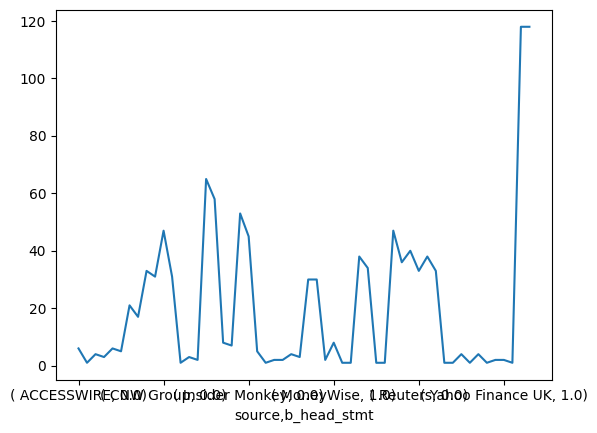

In [137]:
df_final.groupby('source').agg('b_head_stmt').value_counts()

In [69]:
def feature_set1(df):
    # df['len_head'] = df['headline'].apply(lambda x: len(x.split())) 
    # df['len_body'] = df['body'].apply(lambda x: len(x.split()))

    # weight of sentiment, depending on which sentiment, the other two weighted against the dominant
    df.loc[df['fb_body_stmt'] == 0, 'fb_body_weight'] = (df['fb_body_posi'] / (df['fb_body_neut'] + df['fb_body_nega']))
    df.loc[df['fb_body_stmt'] == 1, 'fb_body_weight'] = (df['fb_body_nega'] / (df['fb_body_posi'] + df['fb_body_neut']))
    df.loc[df['fb_body_stmt'] == 2, 'fb_body_weight'] = (df['fb_body_neut'] / (df['fb_body_posi'] + df['fb_body_nega']))
    df.loc[df['fb_head_stmt'] == 0, 'fb_head_weight'] = (df['fb_head_posi'] / (df['fb_head_neut'] + df['fb_head_nega']))
    df.loc[df['fb_head_stmt'] == 1, 'fb_head_weight'] = (df['fb_head_nega'] / (df['fb_head_posi'] + df['fb_head_neut']))
    df.loc[df['fb_head_stmt'] == 2, 'fb_head_weight'] = (df['fb_head_neut'] / (df['fb_head_posi'] + df['fb_head_nega']))

    # do the headlines and body sentiments align
    df.loc[df['b_body_stmt'] == df['b_head_stmt'], 'b_alignment'] = 1
    df.loc[df['b_body_stmt'] != df['b_head_stmt'], 'b_alignment'] = 0
    df.loc[df['fb_body_stmt'] == df['fb_head_stmt'], 'fb_alignment'] = 1
    df.loc[df['fb_body_stmt'] != df['fb_head_stmt'], 'fb_alignment'] = 0
    df.loc[df['b_alignment'] == df['fb_alignment'], 'all_alignment'] = 1
    df.loc[df['b_alignment'] != df['fb_alignment'], 'all_alignment'] = 0

    # get dummies
    # df = pd.concat([df, pd.get_dummies(df['source'], prefix='source')], axis=1)
    # df = pd.concat([df, pd.get_dummies(df['company'], prefix='company')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['b_body_stmt'], prefix='body_stmt')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['b_head_stmt'], prefix='head_stmt')], axis=1)

    df = pd.concat([df, pd.get_dummies(df['fb_body_stmt'], prefix='body_stmt')], axis=1)
    df = pd.concat([df, pd.get_dummies(df['fb_head_stmt'], prefix='head_stmt')], axis=1)

    columns_to_drop = [ # useless columns 'level_0', 'index', 'date', 'url', 'level_0',
    'headline', 'body', 'source', 'company', # Categorical columns 'Date', 
    # 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',  # Financial columns 'len_head', 'len_body'
    ]

    df_final = df.drop(columns=columns_to_drop).reset_index(drop=True)

    return df_final

In [70]:
df = feature_set1(df_final)

In [71]:
df.columns

Index(['target', 'fb_body_posi', 'fb_body_nega', 'fb_body_neut',
       'fb_head_posi', 'fb_head_nega', 'fb_head_neut', 'fb_body_stmt',
       'fb_head_stmt', 'b_body_posi', 'b_body_nega', 'b_body_stmt',
       'b_head_posi', 'b_head_nega', 'b_head_stmt', 'len_head', 'len_body',
       'fb_body_weight', 'fb_head_weight', 'b_alignment', 'fb_alignment',
       'all_alignment', 'body_stmt_0.0', 'body_stmt_1.0', 'head_stmt_0.0',
       'head_stmt_1.0', 'body_stmt_0', 'body_stmt_1', 'body_stmt_2',
       'head_stmt_0', 'head_stmt_1', 'head_stmt_2'],
      dtype='object')

In [ ]:
def feature_set_engineering_application(df_sentiment):
    columns_to_drop = ['date', 'url', # useless columns 'level_0', 'index', 
    'Date', 'headline', 'body', 'source' # Categorical columns
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',  # Financial columns 'len_head', 'len_body'
    ]
    df1 = feature_set1(df)

In [58]:
def features(df_sentiment):
    # all on in set 1

    # df_sentiment['len_head'] = df_sentiment['headline'].apply(lambda x: len(x.split())) # removed in set 3
    # df_sentiment['len_body'] = df_sentiment['body'].apply(lambda x: len(x.split())) # removed in set 3

    columns_to_drop = ['level_0', 'index', 'date', 'url', # useless columns
    'Date', 'headline', 'body', # Categorical columns
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'len_head', 'len_body' # Financial columns
    ]

    df = df_sentiment.drop(columns=columns_to_drop).reset_index()

    # weight of sentiment, depending on which sentiment, the other two weighted against the dominant
    # df.loc[df['body_stmt'] == 0, 'body_weight'] = (df['body_posi'] / (df['body_neut'] + df['body_nega'])) # removed in set 4
    # df.loc[df['body_stmt'] == 1, 'body_weight'] = (df['body_nega'] / (df['body_posi'] + df['body_neut'])) # removed in set 4
    # df.loc[df['body_stmt'] == 2, 'body_weight'] = (df['body_neut'] / (df['body_posi'] + df['body_nega'])) # removed in set 4
    # df.loc[df['head_stmt'] == 0, 'head_weight'] = (df['head_posi'] / (df['head_neut'] + df['head_nega'])) # removed in set 4
    # df.loc[df['head_stmt'] == 1, 'head_weight'] = (df['head_nega'] / (df['head_posi'] + df['head_neut'])) # removed in set 4
    # df.loc[df['head_stmt'] == 2, 'head_weight'] = (df['head_neut'] / (df['head_posi'] + df['head_nega'])) # removed in set 4

    # do the headlines and body sentiments align
    # df.loc[df['body_stmt'] == df['head_stmt'], 'alignment'] = 1 # removed in set 5
    # df.loc[df['body_stmt'] != df['head_stmt'], 'alignment'] = 0 # removed in set 5

    # get dummies
    # df = pd.concat([df, pd.get_dummies(df['source'], prefix='source')], axis=1) #- removed on set 2
    # df = pd.concat([df, pd.get_dummies(df['company'], prefix='company')], axis=1) #- removed on set 2
    # df = pd.concat([df, pd.get_dummies(df['body_stmt'], prefix='body_stmt')], axis=1)
    # df = pd.concat([df, pd.get_dummies(df['head_stmt'], prefix='head_stmt')], axis=1)
    
    df.drop(columns='index', inplace=True)

    return df

## ML Pipeline

#### ML Modules

In [72]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb

import warnings
# from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()  
xboost = xgb.XGBClassifier()

#### Datamodel Functions

In [73]:
def datamodel_creation(df):
    # Identify numeric and categorical features, columns to keep and drop
    drop_feats = ['target', 'b_body_stmt', 'b_head_stmt', 'fb_body_stmt', 'fb_head_stmt']
    target_feat = ['target']

    df_target = df[target_feat]
    df_pipeline = df.drop(columns=drop_feats)
    model_feats = df_pipeline.columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(df_pipeline, df_target, test_size=0.20, random_state=42)

    datamodel = [X_train, y_train, X_test, y_test]

    return datamodel, model_feats

#### Metrics and Pipeline

In [74]:
def metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    metrics_list = [recall, precision, accuracy, f1, roc_auc]
    metrics_tag = ['recall', 'precision', 'accuracy', 'f1 score', 'roc auc score']
    metrics_def = [
        '--> Recall is the fraction correctly identified as positive out of all predicted positives',
        '--> Precision is the fraction correctly identified as positive out of all positives',
        '--> Accuracy is the fraction of predictions our model got correct',
        '--> F1 Score is the harmonic mean of models precision and recall',
        '--> ROC-AUC Score shows the performance of the model at all classification levels']

    for i in range(len(metrics_list)):
        print(f'the {metrics_tag[i]} is: {metrics_list[i]} {metrics_def[i]}')

    print(f'the confusion matrix is:\n{cm}')

    return metrics_list

In [128]:
def pipeline(model, datamodel):

    numeric_transform = Pipeline([
        ('scaling', StandardScaler()),
        ('select_k_best', SelectKBest(k=3))
    ])

    # categorical_transform = Pipeline([
    #     ('one-hot-encode', OneHotEncoder(sparse=False)),
    #     ('pca', PCA(n_components=3))
    # ])

    preprocessing = ColumnTransformer([
        ('numeric', numeric_transform, model_feats),
        # ('categorical', categorical_transform, cat_feats)
    ])

    union = FeatureUnion([
        ('pca', PCA(n_components=3)),
        ('select_k_best', SelectKBest(k=3))
    ])

    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        ('features', union),
        ('model', model)
    ])

    if model == lr:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'model__penalty': ['1l', 'l2', 'elasticnet', 'none']
        }
    elif model == rfc:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            # 'model__criterion' : ["gini", "entropy", "log_loss"],
            'model__max_depth': [10, 25, 50, 100],
            'model__n_jobs' : [-1],
            # 'model__max_features': ["sqrt", "log2", None],
            'model__n_estimators': [10, 50, 75, 100, 250]
        }
    elif model == gbc:
        params = {
            'features__pca__n_components': [1, 2, 3, 4, 5],
            'features__select_k_best__k': [1, 2, 3, 4, 5],
            'model__n_estimators': [50, 75, 100, 250, 500]
        }
    elif model == xboost:
        params = {
        'model__max_depth': [2, 3, 4, 5, 6],
        'model__eta': [1, 2, 3], 
        'model__nthread': [-1],
        'model__objective': ['binary:logistic']
        }

    # model = pipeline.fit(datamodel[0], datamodel[1])

    grid_search = GridSearchCV(pipeline, params, verbose=0)
    model = grid_search.fit(datamodel[0], datamodel[1])
    print(f'The parameters were:\n{grid_search.best_params_}') 
    print(f'The best score was: {grid_search.best_score_}')

    y_pred = model.predict(datamodel[2])
    y_prob = model.predict_proba(datamodel[2])
    y_best = model.best_score_
    # y_feats = grid_search.feature_importances_

    metrics_list = metrics(datamodel[3], y_pred)
    
    return model, metrics_list, y_prob, y_pred, y_best, # y_feats

#### Function Runs

In [115]:
# df = features(df_sentiment)
datamodel, model_feats = datamodel_creation(df)

In [116]:
# 16.8s
model_lr, metrics_lr, prob_lr, pred_lr, best_lr, feats_lr = pipeline(lr, datamodel)

The parameters were:
{'features__pca__n_components': 1, 'features__select_k_best__k': 2, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
The best score was: 0.520656814449918


AttributeError: 'Pipeline' object has no attribute 'feature_importance'

In [78]:
# 1m 25.6s
model_rfc, metrics_rfc, prob_rfc, pred_rfc, best_rfc, feats_rfc = pipeline(rfc, datamodel)

The parameters were:
{'features__pca__n_components': 2, 'features__select_k_best__k': 3, 'model__max_depth': 100, 'model__n_estimators': 10, 'model__n_jobs': -1}
The best score was: 0.5561904761904761
the recall is: 0.4392523364485981 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.5280898876404494 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5321100917431193 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.4795918367346939 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5304369790351098 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[69 42]
 [60 47]]


In [79]:
# 21.7s
model_gbc, metrics_gbc, prob_gbc, pred_gbc, best_gbc, feats_gbc = pipeline(gbc, datamodel)

The parameters were:
{'features__pca__n_components': 3, 'features__select_k_best__k': 3, 'model__n_estimators': 500}
The best score was: 0.5527027914614121
the recall is: 0.4205607476635514 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.5172413793103449 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5229357798165137 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.46391752577319584 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5210911846425865 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[69 42]
 [62 45]]


In [129]:
# 2.8s
model_xgb, metrics_xgb, prob_xgb, pred_xgb, best_xgb = pipeline(xboost, datamodel) #  feats_xgb

The parameters were:
{'model__eta': 2, 'model__max_depth': 5, 'model__nthread': -1, 'model__objective': 'binary:logistic'}
The best score was: 0.5481970443349754
the recall is: 0.616822429906542 --> Recall is the fraction correctly identified as positive out of all predicted positives
the precision is: 0.528 --> Precision is the fraction correctly identified as positive out of all positives
the accuracy is: 0.5412844036697247 --> Accuracy is the fraction of predictions our model got correct
the f1 score is: 0.5689655172413793 --> F1 Score is the harmonic mean of models precision and recall
the roc auc score is: 0.5426454491875052 --> ROC-AUC Score shows the performance of the model at all classification levels
the confusion matrix is:
[[52 59]
 [41 66]]


#### Model Metrics and Graphics

In [101]:
model_rfc.feature_importances_

AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

AttributeError: 'DataFrame' object has no attribute 'set_axis_bgcolor'

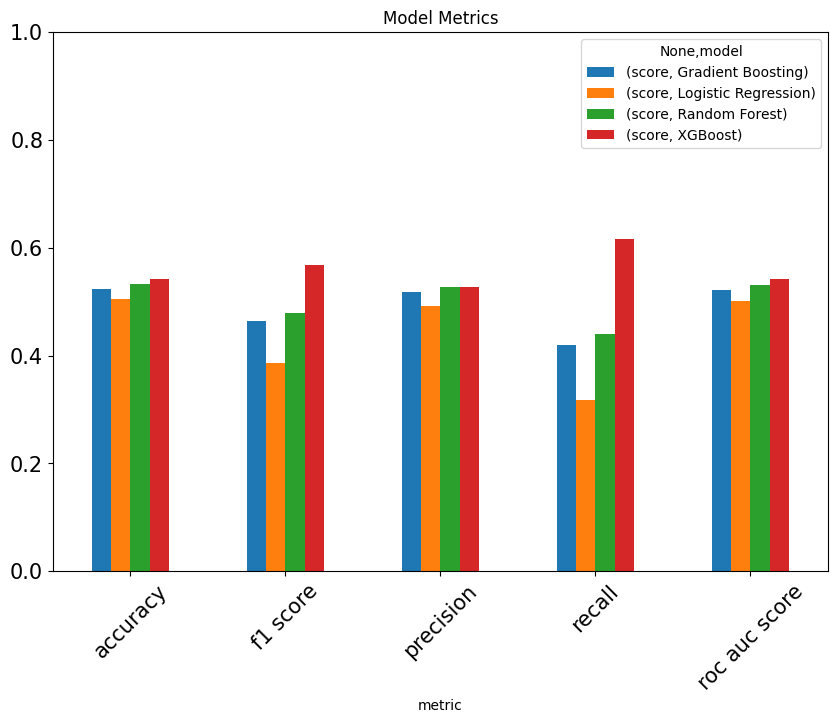

In [100]:
import numpy as np
metrics_tag = ['recall', 'precision', 'accuracy', 'f1 score', 'roc auc score']
model_bests = [best_lr, best_rfc, best_gbc, best_xgb]

df_met_lr = pd.DataFrame(np.array(metrics_lr).reshape(1,-1), columns=metrics_tag).T
df_met_lr['model'] = 'Logistic Regression'
df_met_rfc = pd.DataFrame(np.array(metrics_rfc).reshape(1,-1), columns=metrics_tag).T
df_met_rfc['model'] = 'Random Forest'
df_met_gbc = pd.DataFrame(np.array(metrics_gbc).reshape(1,-1), columns=metrics_tag).T
df_met_gbc['model'] = 'Gradient Boosting'
df_met_xgb = pd.DataFrame(np.array(metrics_xgb).reshape(1,-1), columns=metrics_tag).T
df_met_xgb['model'] = 'XGBoost'


df_met = pd.concat([df_met_lr, df_met_rfc, df_met_gbc, df_met_xgb])
df_met = df_met.reset_index()
# df_met = df_met[['model', 'recall', 'precision', 'accuracy', 'f1 score']]
df_met = df_met.rename(columns={'index':'metric', 0:'score'})
df_met

graph = pd.pivot_table(
    df_met,
    values=['score'],
    index=['metric'],
    columns=['model'],
    aggfunc=np.sum,
)

# graph.style.use('dark_background')

graph.plot(
    kind='bar', 
    ylim=(0,1),
    title='Model Metrics',
    figsize=(10,7),
    fontsize=15,
    rot=45,
    
)

graph.set_axis_bgcolor('b')

## Testing Pipeline Function

#### Metrics Tracker

In [14]:
best_models_list = []
feat_dict = {}
metrics_list = []

In [35]:
def metrics_dictionary(df_metrics, df, feat_dict, metrics_list, model_bests, test_num):
    
    feature_list = df.columns.to_list()
    df_metrics['features'] = f'set {test_num}'
    feat_dict[f'set {test_num}']  = feature_list
    metrics_list.append(df_metrics)
    best_models_list.append(model_bests)

    return feat_dict, metrics_list

In [69]:
feature_set = 5
feat_dict, metrics_list = metrics_dictionary(df_met, datamodel[0], feat_dict, metrics_list, best_models_list, feature_set)

In [70]:
feat_dict['set 5']

['body_posi', 'body_nega', 'body_neut', 'head_posi', 'head_nega', 'head_neut']

## To delete

In [62]:
df_sentiment['len_head'] = df_sentiment['headline'].apply(lambda x: len(x.split()))
df_sentiment['len_body'] = df_sentiment['body'].apply(lambda x: len(x.split()))

columns_to_drop = ['level_0', 'index', 'date', 'url', # useless columns
'Date', 'headline', 'body', # Categorical columns
'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume' # Financial columns
]

df = df_sentiment.drop(columns=columns_to_drop).reset_index()

In [63]:
# weight of sentiment, depending on which sentiment, the other two weighted against the dominant
df.loc[df['body_stmt'] == 0, 'body_weight'] = (df['body_posi'] / (df['body_neut'] + df['body_nega']))
df.loc[df['body_stmt'] == 1, 'body_weight'] = (df['body_nega'] / (df['body_posi'] + df['body_neut']))
df.loc[df['body_stmt'] == 2, 'body_weight'] = (df['body_neut'] / (df['body_posi'] + df['body_nega']))
df.loc[df['head_stmt'] == 0, 'head_weight'] = (df['head_posi'] / (df['head_neut'] + df['head_nega']))
df.loc[df['head_stmt'] == 1, 'head_weight'] = (df['head_nega'] / (df['head_posi'] + df['head_neut']))
df.loc[df['head_stmt'] == 2, 'head_weight'] = (df['head_neut'] / (df['head_posi'] + df['head_nega']))

# do the headlines and body sentiments align
df.loc[df['body_stmt'] == df['head_stmt'], 'alignment'] = 1
df.loc[df['body_stmt'] != df['head_stmt'], 'alignment'] = 0

# get dummies
df = pd.concat([df, pd.get_dummies(df['source'], prefix='source')], axis=1)
df = pd.concat([df, pd.get_dummies(df['company'], prefix='company')], axis=1)
df = pd.concat([df, pd.get_dummies(df['body_stmt'], prefix='body_stmt')], axis=1)
df = pd.concat([df, pd.get_dummies(df['head_stmt'], prefix='head_stmt')], axis=1)

#### To delete

In [ ]:
# Identify numeric and categorical features, columns to keep and drop
drop_feats = ['target', 'company','source', 'company', 'body_stmt', 'head_stmt']
target_feat = ['target']

In [ ]:
df_target = df[target_feat]
df_pipeline = df.drop(columns=drop_feats)
model_feats = df_pipeline.columns.tolist()

In [ ]:
df_pipeline.head()

,index,body_posi,body_nega,body_neut,head_posi,head_nega,head_neut,len_head,len_body,body_weight,...,company_TMQ,company_UEC,company_VALE,company_WPM,body_stmt_0,body_stmt_1,body_stmt_2,head_stmt_0,head_stmt_1,head_stmt_2
0,0,0.047281,0.036910,0.915810,0.742239,0.074669,0.183092,4,377,10.877876,...,0,0,0,0,0,0,1,1,0,0
1,1,0.393008,0.186979,0.420013,0.151248,0.067651,0.781101,8,727,0.724177,...,0,0,0,0,0,0,1,0,0,1
2,2,0.027425,0.366215,0.606360,0.194353,0.057130,0.748516,11,720,1.540392,...,0,0,0,0,0,0,1,0,0,1
3,3,0.135358,0.262391,0.602251,0.553251,0.045959,0.400790,10,767,1.514149,...,0,0,0,0,0,0,1,1,0,0
4,4,0.379966,0.032846,0.587188,0.175742,0.046158,0.778100,11,562,1.422409,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_pipeline, df_target, test_size=0.33, random_state=42)

In [ ]:
datamodel = [X_train, y_train, X_test, y_test]

#### UPDATE THIS WHEN RUNNING NEW FEATURES

In [ ]:
df_met['features'] = 'set 1'

In [ ]:
features_dictionary = {
    'set 1': feature_list
}

In [ ]:
features_dictionary.items()

dict_items([('set 1', ['index', 'body_posi', 'body_nega', 'body_neut', 'head_posi', 'head_nega', 'head_neut', 'len_head', 'len_body', 'body_weight', 'head_weight', 'alignment', 'source_ ACCESSWIRE', 'source_ American City Business Journals', 'source_ Barrons.com', 'source_ Benzinga', 'source_ Bloomberg', 'source_ Business Wire', 'source_ CNW Group', 'source_ FX Empire', 'source_ Financial Times', 'source_ GlobeNewswire', 'source_ GuruFocus.com', 'source_ Insider Monkey', 'source_ Investing.com', 'source_ Investopedia', "source_ Investor's Business Daily", 'source_ InvestorPlace', 'source_ MarketWatch', 'source_ MoneyWise', "source_ Moody's", 'source_ Motley Fool', 'source_ Newsfile', 'source_ Oilprice.com', 'source_ PR Newswire', 'source_ Reuters', 'source_ Simply Wall St.', 'source_ The Wall Street Journal', 'source_ TheStreet.com', 'source_ TipRanks', 'source_ Yahoo Finance UK', 'source_ Yahoo Finance Video', 'source_ Zacks', 'company_ALB', 'company_BHP', 'company_CDE', 'company_DMLP

In [ ]:
metrics_list.append(df_met)

In [ ]:
metrics_list

[           metric     score                model features
 0          recall  0.366460  Logistic Regression    set 1
 1       precision  0.412587  Logistic Regression    set 1
 2        accuracy  0.483333  Logistic Regression    set 1
 3        f1 score  0.388158  Logistic Regression    set 1
 4   roc auc score  0.472175  Logistic Regression    set 1
 5          recall  0.440994        Random Forest    set 1
 6       precision  0.422619        Random Forest    set 1
 7        accuracy  0.480556        Random Forest    set 1
 8        f1 score  0.431611        Random Forest    set 1
 9   roc auc score  0.476778        Random Forest    set 1
 10         recall  0.490683    Gradient Boosting    set 1
 11      precision  0.438889    Gradient Boosting    set 1
 12       accuracy  0.491667    Gradient Boosting    set 1
 13       f1 score  0.463343    Gradient Boosting    set 1
 14  roc auc score  0.491573    Gradient Boosting    set 1
 15         recall  0.465839              XGBoost    set